##ThinkDSP

This notebook contains solutions to exercises in Chapter 6: Discrete Cosine Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [35]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import scipy.fftpack

import autocorr
import dct

%matplotlib inline

**Exercise:** In this chapter I claim that `analyze1` takes time proportional
to $n^3$ and `analyze2` takes time proportional to $n^2$.  To
see if that's true, run them on a range of input sizes and time
them.  In IPython, you can use the magic command `%timeit`.

If you plot run time versus input size on a log-log scale, you
should get a straight line with slope 3 for  `analyze1` and
slope 2 for `analyze2`.  You also might want to test `dct_iv`
and `scipy.fftpack.dct`.

I'll start with a noise signal and an array of power-of-two sizes

In [36]:
signal = thinkdsp.UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0)

ns = 2 ** np.arange(6, 14)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096, 8192])

The following function takes an array of results from a timing experiment, plots the results, and fits a straight line.

In [37]:
def plot_bests(bests):    
    thinkplot.plot(ns, bests)
    thinkplot.config(xscale='log', yscale='log', legend=False)
    
    x = np.log(ns)
    y = np.log(bests)
    t = scipy.stats.linregress(x,y)
    slope = t[0]

    return slope

Here are the results for 'analyze1'.

1000 loops, best of 3: 428 µs per loop
1000 loops, best of 3: 1.71 ms per loop
100 loops, best of 3: 7.41 ms per loop
10 loops, best of 3: 33.6 ms per loop
10 loops, best of 3: 175 ms per loop
1 loops, best of 3: 942 ms per loop
1 loops, best of 3: 5.46 s per loop
1 loops, best of 3: 35.3 s per loop


2.3316015140218611

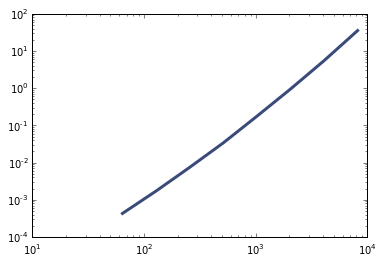

In [38]:
results = []
for N in ns:
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -o dct.analyze1(ys, freqs, ts)
    results.append(result)

bests = [result.best for result in results]

thinkplot.preplot(3)
plot_bests(bests)

The line is curved, which suggests that we have not reached the array size where the runtime shows asymptotic behavior.  As I ran this with larger array sizes, the estimated slope continued to increase.

Here are the results for 'analyze2':

1000 loops, best of 3: 355 µs per loop
1000 loops, best of 3: 1.39 ms per loop
100 loops, best of 3: 5.53 ms per loop
10 loops, best of 3: 22 ms per loop
10 loops, best of 3: 88.7 ms per loop
1 loops, best of 3: 374 ms per loop
1 loops, best of 3: 1.5 s per loop
1 loops, best of 3: 5.91 s per loop


2.0093587673451991

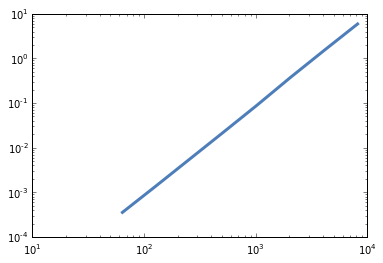

In [39]:
results = []
for N in ns:
    ts = (0.5 + np.arange(N)) / N
    freqs = (0.5 + np.arange(N)) / 2
    ys = noise.ys[:N]
    result = %timeit -o dct.analyze2(ys, freqs, ts)
    results.append(result)

bests2 = [result.best for result in results]
plot_bests(bests2)

`analyze2` is faster, and the estimated slope is close to the value we expected.

Here are the results for the `scipy.fftpack.dct`

The slowest run took 5.81 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 5.87 µs per loop
100000 loops, best of 3: 6.55 µs per loop
100000 loops, best of 3: 7.29 µs per loop
100000 loops, best of 3: 9.11 µs per loop
100000 loops, best of 3: 12.7 µs per loop
10000 loops, best of 3: 20.7 µs per loop
10000 loops, best of 3: 39.8 µs per loop
10000 loops, best of 3: 82.5 µs per loop


0.53204027057913872

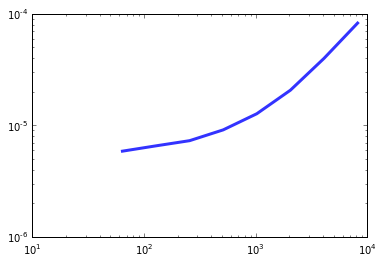

In [42]:
results = []
for N in ns:
    ys = noise.ys[:N]
    result = %timeit -o scipy.fftpack.dct(ys, type=3)
    results.append(result)

bests3 = [result.best for result in results]
plot_bests(bests3)

This implementation of dct is even faster.  The line is curved, which means either we haven't seen the asymptotic behavior yet, or the asymptotic behavior is not a simple exponent of $n$.  In fact, as we'll see soon, the run time is proportional to $n \log n$.

The following figure shows all three curves on the same axes.

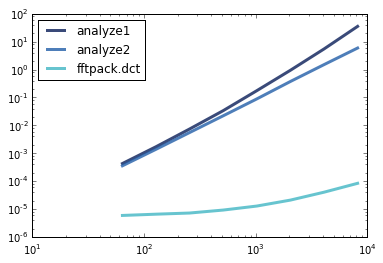

In [41]:
thinkplot.preplot(3)
thinkplot.plot(ns, bests, label='analyze1')
thinkplot.plot(ns, bests2, label='analyze2')
thinkplot.plot(ns, bests3, label='fftpack.dct')
thinkplot.config(xscale='log', yscale='log', legend=True, loc='upper left')

5) One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.

Implement a version of this algorithm and apply it to a recording of music or speech. How many components can you eliminate before the difference is perceptible?

`thinkdsp` provides a class, `Dct` that is similar to a `Spectrum`, but which uses DCT instead of FFT.  We can use it to make a DCT Spectrogram; the following is almost identical to `Wave.make_spectrogram`:

In [4]:
def make_dct_spectrogram(wave, seg_length, window_func=np.hamming):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment
    window_func: function used to compute the window

    returns: Spectrogram
    """
    n = len(wave.ys)
    window = window_func(seg_length)

    start, end, step = 0, seg_length, seg_length / 2
    spec_map = {}

    while end < n:
        ys = wave.ys[start:end] * window

        t = (start + end) / 2.0 / wave.framerate
        spec_map[t] = thinkdsp.Wave(ys, wave.framerate).make_dct()

        start += step
        end += step

    return thinkdsp.Spectrogram(spec_map, seg_length, window_func)

As an example, I'll use a recording of a saxophone:

In [50]:
wave = thinkdsp.read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Here's a short segment:

In [51]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

And here's the DCT of that segment:

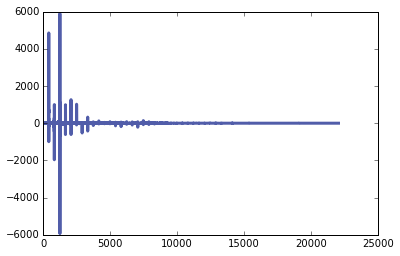

In [52]:
seg_dct = segment.make_dct()
seg_dct.plot()

There are only a few harmonics with substantial amplitude, and many entries near zero.

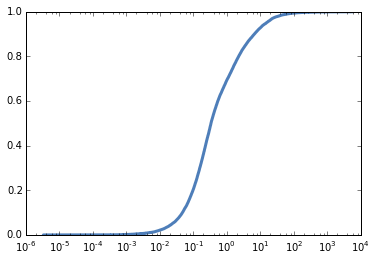

In [53]:
cdf = thinkstats2.Cdf(np.abs(seg_dct.amps))
thinkplot.cdf(cdf)
thinkplot.config(xscale='log', legend=False)

The following function takes a DCT and sets elements below `thresh` to 0.

In [54]:
def compress(dct, thresh=1000):
    count = 0
    for i, amp in enumerate(dct.amps):
        if abs(amp) < thresh:
            dct.amps[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

To test `compress`, I'll make a DCT spectrogram and then compress each segment.

The output shows the number of elements eliminated and the compression factor.

In [67]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.iteritems()):
    compress(dct, thresh=1000)

1004	1024	98.046875
1003	1024	97.94921875
996	1024	97.265625
1009	1024	98.53515625
1010	1024	98.6328125
1005	1024	98.14453125
999	1024	97.55859375
1006	1024	98.2421875
1006	1024	98.2421875
997	1024	97.36328125
999	1024	97.55859375
1006	1024	98.2421875
1005	1024	98.14453125
1002	1024	97.8515625
1005	1024	98.14453125
1004	1024	98.046875
1000	1024	97.65625
1007	1024	98.33984375
999	1024	97.55859375
1005	1024	98.14453125
1001	1024	97.75390625
1009	1024	98.53515625
1007	1024	98.33984375
1007	1024	98.33984375
941	1024	91.89453125
670	1024	65.4296875
669	1024	65.33203125
871	1024	85.05859375
927	1024	90.52734375
925	1024	90.33203125
904	1024	88.28125
848	1024	82.8125
707	1024	69.04296875
742	1024	72.4609375
760	1024	74.21875
788	1024	76.953125
806	1024	78.7109375
805	1024	78.61328125
819	1024	79.98046875
837	1024	81.73828125
844	1024	82.421875
824	1024	80.46875
815	1024	79.58984375
840	1024	82.03125
838	1024	81.8359375
837	1024	81.73828125
843	1024	82.32421875
823	1024	80.37109375
851	1024	83

In most segments, the compression 60-80%.

To hear what it sounds like, we can convert the spectrogram back to a wave and play it.

In [68]:
wave2 = spectro.make_wave()
wave2.make_audio()

And here's the original again for comparison.

In [69]:
wave.make_audio()

As an experiment, you might try increasing `thresh` to see when the effect of compression becomes audible (to you).

Also, you might try compressing a noise signal.